In [1]:
%matplotlib inline
import os.path
import sys
from inspect import getsourcefile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import linear_model, datasets
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Custom modules
from aplib import aplib

In [2]:
# Customizable function to transform loss data
def transform_losses(losses):
    return np.log(losses + 200)

In [3]:
# Import data set
train_file_loc = os.path.expanduser("~/Documents/springboard_files/springboard_cap1/data/train.csv")
all_data = pd.read_csv(train_file_loc)

# Test data provided does not have losses, so use CV to create test sample
#test_file_loc = os.path.expanduser("~/Documents/springboard_files/springboard_cap1/data/test.csv")
#test_data = pd.read_csv(test_file_loc)

# Print sample data
all_data.head(5)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [4]:
# Load all data
#load_rows = 20000
load_rows = all_data.shape[0]
train_data = all_data.loc[:load_rows-1,:]
train_losses = all_data.loc[:load_rows-1,"loss"]
all_train_losses = all_data.loc[:load_rows-1,"loss"]

# Create separate DataFrames for continuous and categorical variables
cat_var = train_data.iloc[:,1:117]
cont_var = train_data.iloc[:,117:-1]

# Encode categorical variables, re-join to continuous variables
dummy_var = pd.get_dummies(cat_var, drop_first=True)
train_data = pd.concat([dummy_var, cont_var], axis=1)
all_train_data = pd.concat([dummy_var, cont_var], axis=1)

# Load test data
#test_load_rows = test_data.shape[0]
#test_data = test_data.loc[:test_load_rows-1,:]
#test_losses = test_data.loc[:test_load_rows-1,"loss"]
train_data, test_data, train_losses, test_losses = train_test_split(train_data,
                                                                    train_losses,
                                                                    test_size=0.1,
                                                                    random_state=3)
test_load_rows = test_data.shape[0]

In [5]:
# Split categorical and continuos variables
cat_var_list = [col for col in list(train_data) if col.startswith('cat')]
cont_var_list = [col for col in list(train_data) if col.startswith('cont')]

In [6]:
box_cox_losses=True

if box_cox_losses==True:
    train_losses, box_cox_data_lambda = scipy.stats.boxcox(train_losses, lmbda=None)
    test_losses = scipy.stats.boxcox(test_losses, lmbda=box_cox_data_lambda)
    all_train_losses = scipy.stats.boxcox(all_train_losses, lmbda=box_cox_data_lambda)
    print box_cox_data_lambda

-0.0398048871747


In [ ]:
# Check for completenes of data, returns 0 if there are entries for each loss data point
if sum(train_data.count(axis=0) != train_losses.size):
    print "Missing data mapped to losses"
else:
    print "No missing data mapped to losses"

In [ ]:
# For categorical variables, create dictionary of unique values
unique_dict = {}
for column in cat_var:
    unique_dict[column]=cat_var[column].unique()

In [ ]:
# List of distributional forms to explore
dist_names = ['norm']#,'lognorm','exponnorm', 'gamma']#, 'beta','norm', 'beta', 'rayleigh', 'norm', 'pareto']

# Call function to plot distribution and return fit information
figure, dist_info = aplib.fit_plot_distribution(train_losses, dist_names, log_scale=False)
print dist_info

In [ ]:
# Plot losses vs. continuous variables
fig, axes = plt.subplots(7,2, figsize=(12,24))

for counter, col in enumerate(cont_var_list):
    axes[counter // 2][counter % 2].scatter(x=train_data[col], y=train_losses)
    axes[counter // 2][counter % 2].set_title(col)

fig.tight_layout()

In [ ]:
# Plot correlation matrix heat map
cont_var_wloss = all_data.iloc[:load_rows-1,117:]
corr = cont_var_wloss.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.25, cbar_kws={"shrink": .75}, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)

In [ ]:
# Identify variables with a degree of correlatin > threshold (between themselves or vs. loss)

threshold = 0.5
sig_dict = {}

sig_counter = 0
for counter1 in range(0, cont_var_wloss.columns.size):
    for counter2 in range(counter1 + 1, cont_var_wloss.columns.size):
        correl, pval = scipy.stats.pearsonr(cont_var_wloss.iloc[:,counter1], cont_var_wloss.iloc[:,counter2])
        if (correl<=-threshold) or (correl>=threshold):
            sig_dict[sig_counter] = {(cont_var_wloss.columns[counter1]):(cont_var_wloss.columns[counter2])}
            sig_counter += 1

sig_dict

In [ ]:
# Plot subset of continous variables and loss with a degree of correlation > threshold
fig, axes = plt.subplots(int(np.ceil((len(sig_dict)+1)/2)),2, figsize=(12,48))

for key, value in sig_dict.iteritems():
    title = ('{} vs {}').format(value.items()[0][0],  value.items()[0][1])
    axes[key // 2, key % 2].scatter(train_data[value.items()[0][0]], train_data[value.items()[0][1]])
    axes[key // 2, key % 2].set_title(title)

fig.tight_layout()

In [ ]:
# Define cross validation scheme
kf_10 = KFold(n_splits=10, shuffle=False, random_state=2)

# Transform variables through PCA
cv_pca = PCA(whiten=False)

# Run through options for alpha parameter
regr = Ridge(fit_intercept=True)
param_grid = {'alpha': [10, 1000]}
ridge_param_eval = GridSearchCV(regr, param_grid, cv=kf_10, scoring='neg_mean_absolute_error')
ridge_param_eval.fit(cv_pca.fit_transform(np.array(all_train_data)), np.array(all_train_losses))
ridge_param_eval.cv_results_

In [ ]:
# Print out optimum parameter
opt_param = ridge_param_eval.cv_results_['params'][ridge_param_eval.cv_results_['rank_test_score'].argmin()]
print opt_param

In [7]:
# Optimal regression parameters based on analysis below
# For analyses based on PCA where variance of vectors is important, num_pca controls max number of features considered

ridge_reg_alpha = 10 #opt_param['alpha']
num_pca = []

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.91 µs


Train R2: 0.48
Train MSE: 0.335
Test MAE: 0.339


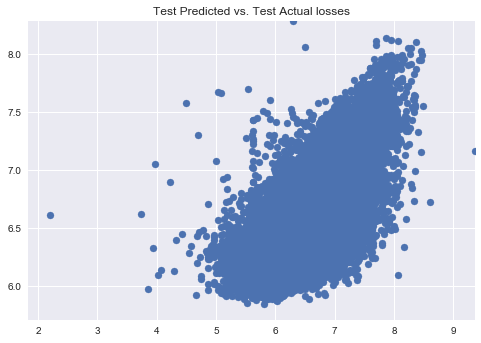

In [10]:
# Run all variables through OLS
% timeit
train_R2, train_MABS, test_MABS, test_scatter_plot, \
loss_pred, test_loss_pred = aplib.fit_OLS(losses=train_losses,
                                          test_losses=test_losses,
                                          X_train=train_data,
                                          X_test=test_data,
                                          apply_pca=True,
                                          ridge_alpha=ridge_reg_alpha)

In [11]:
def invboxcox(y,ld):
    return (ld*y+1)**(1/ld)

if box_cox_losses==True:
    loss_pred = invboxcox(loss_pred, box_cox_data_lambda)
    test_loss_pred = invboxcox(test_loss_pred, box_cox_data_lambda)
    test_losses = invboxcox(test_losses, box_cox_data_lambda)
    train_losses = invboxcox(train_losses, box_cox_data_lambda)

1265.15651985
1260.23180829


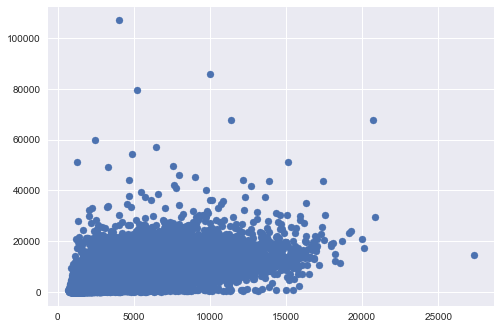

In [12]:
from sklearn.metrics import mean_absolute_error
print mean_absolute_error(test_loss_pred, test_losses)
print mean_absolute_error(loss_pred, train_losses)
plt.scatter(x=loss_pred, y=train_losses)

In [11]:
# For analysis where variance of input data is an important feature does not whiten feature data
opt_regr = Ridge(alpha=ridge_reg_alpha)
max_factors = 110

dummy_var = pd.get_dummies(cat_var, drop_first=True)
all_var = pd.concat([dummy_var, cont_var], axis=1)

# Identify PCA
pca = PCA(whiten=False)
all_var = pca.fit_transform(all_var)
all_var.shape

# Add constant
all_var = np.insert(all_var, 0, 1, axis=1)

mse = []
for i in np.arange(1,max_factors+2):
    score = -cross_val_score(opt_regr, all_var[:,:i], 
                             all_data.loc[:load_rows-1,"loss"], 
                             cv=kf_10, scoring='neg_mean_absolute_error').mean()
    mse.append(score)
    print 'Up to {0} PCA factors analyzed\r'.format(i)

NameError: name 'kf_10' is not defined

In [ ]:
import matplotlib.ticker
fig,ax = plt.subplots()
ax.plot(np.arange(1,max_factors+2), mse[0:])
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_xlabel("Number of PCA factors")
#ax.set_xticks(np.arange(1,max_factors+1))
ax.set_ylabel("Mean Abasolute Error")
ax.set_title("Mean Abasolute Error vs. Number of PCA Factors")